<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#[TODO]-정답-코드-구현-Unet++-" data-toc-modified-id="[TODO]-정답-코드-구현-Unet++--5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span><font color="blue">[TODO] 정답 코드 구현 Unet++ </font></a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span><ul class="toc-item"><li><span><a href="#plot_examples()-시각화-함수-정의" data-toc-modified-id="plot_examples()-시각화-함수-정의-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span><code>plot_examples()</code> 시각화 함수 정의</a></span><ul class="toc-item"><li><span><a href="#train-set-시각화" data-toc-modified-id="train-set-시각화-9.1.1"><span class="toc-item-num">9.1.1&nbsp;&nbsp;</span>train set 시각화</a></span></li><li><span><a href="#validation-set-시각화" data-toc-modified-id="validation-set-시각화-9.1.2"><span class="toc-item-num">9.1.2&nbsp;&nbsp;</span>validation set 시각화</a></span></li><li><span><a href="#test-set-시각화" data-toc-modified-id="test-set-시각화-9.1.3"><span class="toc-item-num">9.1.3&nbsp;&nbsp;</span>test set 시각화</a></span></li></ul></li></ul></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li></ul></div>

In [2]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-PCIE-32GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [2]:
batch_size = 16   # Mini-batch size
num_epochs = 40
learning_rate = 0.0001

In [3]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [4]:
%matplotlib inline

dataset_path  = '../input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 26240
Number of images: 3272


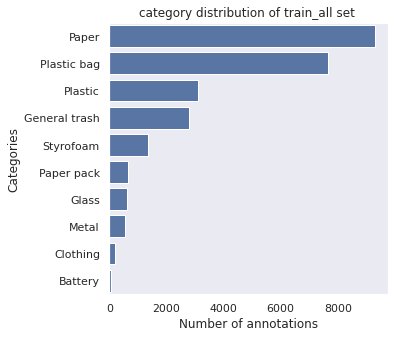

In [5]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [6]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [7]:
# class (Categories) 에 따른 index 확인 (0~10 : 총 11개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,General trash,2782.0
2,Paper,9311.0
3,Paper pack,659.0
4,Metal,562.0
5,Glass,610.0
6,Plastic,3090.0
7,Styrofoam,1343.0
8,Plastic bag,7643.0
9,Battery,63.0


## 데이터 전처리 함수 정의 (Dataset)

In [8]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [9]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [10]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [11]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [12]:
# # train_loader의 output 결과(image 및 mask) 확인
# for imgs, masks, image_infos in train_loader:
#     image_infos = image_infos[0]
#     temp_images = imgs
#     temp_masks = masks
#     break

# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# print('image shape:', list(temp_images[0].shape))
# print('mask shape: ', list(temp_masks[0].shape))
# print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

# ax1.imshow(temp_images[0].permute([1,2,0]))
# ax1.grid(False)
# ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

# ax2.imshow(temp_masks[0])
# ax2.grid(False)
# ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

# plt.show()

In [13]:
# # val_loader의 output 결과(image 및 mask) 확인
# for imgs, masks, image_infos in val_loader:
#     image_infos = image_infos[0]
#     temp_images = imgs
#     temp_masks = masks
    
#     break

# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# print('image shape:', list(temp_images[0].shape))
# print('mask shape: ', list(temp_masks[0].shape))

# print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

# ax1.imshow(temp_images[0].permute([1,2,0]))
# ax1.grid(False)
# ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

# ax2.imshow(temp_masks[0])
# ax2.grid(False)
# ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

# plt.show()

In [14]:
# # test_loader의 output 결과(image) 확인
# for imgs, image_infos in test_loader:
#     image_infos = image_infos[0]
#     temp_images = imgs
    
#     break

# fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

# print('image shape:', list(temp_images[0].shape))

# ax1.imshow(temp_images[0].permute([1,2,0]))
# ax1.grid(False)
# ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

# plt.show()

## baseline model

### <font color='blue'>[TODO] 정답 코드 구현 Unet++ </font> 
![image.png](http://drive.google.com/uc?export=view&id=1CQRLAiLVbNFXs5iHUzYWcYZBt83xfgWr)

In [5]:
# 출처 : https://jinglescode.github.io/2019/12/02/biomedical-image-segmentation-u-net-nested/
import torch
import torch.nn as nn

class conv_block_nested(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)
        return output

class UNetPlusPlus(nn.Module):

    def __init__(self, in_ch=3, out_ch=1, n1=64, height=512, width=512, supervision=True):
        super(UNetPlusPlus, self).__init__()

        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.ModuleList([nn.Upsample(size=(height//(2**c), width//(2**c)), mode='bilinear', align_corners=True) for c in range(4)])
        self.supervision = supervision

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.seg_outputs = nn.ModuleList([nn.Conv2d(filters[0], out_ch, kernel_size=1, padding=0) for _ in range(4)])

    def forward(self, x):
        seg_outputs = []
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up[0](x1_0)], 1))
        seg_outputs.append(self.seg_outputs[0](x0_1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up[1](x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up[0](x1_1)], 1))
        seg_outputs.append(self.seg_outputs[1](x0_2))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up[2](x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up[1](x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up[0](x1_2)], 1))
        seg_outputs.append(self.seg_outputs[2](x0_3))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up[3](x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up[2](x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up[1](x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up[0](x1_3)], 1))
        seg_outputs.append(self.seg_outputs[3](x0_4))

        if self.supervision: 
            return seg_outputs
        else:
            return seg_outputs[-1]

In [6]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test

model = UNetPlusPlus(out_ch=11, supervision=False)
x = torch.randn([2, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)



input shape :  torch.Size([2, 3, 512, 512])
output shape :  torch.Size([2, 11, 512, 512])


In [3]:

import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=11,                      # model output channels (number of classes in your dataset)
)

x = torch.randn([2, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())
model = model.to(device)


input shape :  torch.Size([2, 3, 512, 512])
output shape :  torch.Size([2, 11, 512, 512])


## train, validation, test 함수 정의

In [18]:
import wandb

def loggin_with_wandb(mode, epoch, step, loss, mIOU, acc):
    if mode == "train":
        wandb.log({
                    f"train_epoch": epoch,
                    f"train_step" : step,
                    f"train_loss" : loss,
                    f"train_mIOU" : mIOU,
                    f"train_acc" : acc
                    })
    else:
        wandb.log({
                    f"valid_epoch": epoch,
                    f"valid_step" : step,
                    f"valid_avrg_loss" : loss,
                    f"valid_mIOU" : mIOU,
                    f"valid_acc" : acc
                    })

In [19]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print(f'Start training..')
    n_class = 11
    best_loss = 9999999
    best_mIoU = 0

    for epoch in range(num_epochs):
        # wandb
        run = wandb.init(
        # Set entity to specify your username or team name
        entity="hyunsoo",
        # Set the project where this run will be logged
        project="semantic-segmetation", 
        # Track hyperparameters and run metadata
        group='experiment-3_Unet++_mIoU',
        name = f"epoch_{epoch}",
        config={
        "Epoch" : epoch, 
        "loss" : "Cross_Entropy",
        "optim" : "Adam",
        "batch_size" : batch_size,
        "learning_rate" : learning_rate
        }
        )
        
        wandb.watch(model)
        model.train()
        
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       
            masks = torch.stack(masks).long() 
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
            
            # device 할당
            model = model.to(device)
            
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
            acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)

            loggin_with_wandb("train", epoch, step, loss, mIoU, acc)
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], \
                        Loss: {round(loss.item(),4)}, mIoU: {round(mIoU,4)}')
             
        # # validation 주기에 따른 loss 출력 및 best model 저장
        # if (epoch + 1) % val_every == 0:
        #     avrg_loss, mIoU = validation(epoch + 1, model, val_loader, criterion, device)
        #     if avrg_loss < best_loss:
        #         print(f"Best performance at epoch: {epoch + 1}")
        #         print(f"Save model in {saved_dir}")
        #         best_loss = avrg_loss
        #         save_model(model, saved_dir)

        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss, val_mIoU = validation(epoch + 1, model, val_loader, criterion, device)
            
            loggin_with_wandb("valid", epoch, step, loss, mIoU, acc)
            #if avrg_loss < best_loss:
            if val_mIoU > best_mIoU:
                print(f"Best performance at epoch: {epoch + 1}")
                print(f"Save model in {saved_dir}")
                #best_loss = avrg_loss
                best_mIoU = val_mIoU
                wandb.log({"best_mIoU" : best_mIoU})
                save_model(model, saved_dir)
        run.finish()

In [20]:
def validation(epoch, model, data_loader, criterion, device):
    print(f'Start validation #{epoch}')
    model.eval()

    with torch.no_grad():
        n_class = 11
        total_loss = 0
        cnt = 0
        
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       
            masks = torch.stack(masks).long()  

            images, masks = images.to(device), masks.to(device)            
            
            # device 할당
            model = model.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
            acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
            loggin_with_wandb("valid", epoch, step, loss, mIoU, acc)
        
        acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        IoU_by_class = [{classes : round(IoU,4)} for IoU, classes in zip(IoU , sorted_df['Categories'])]

        wandb.log({list(IoU_by_class[i].keys())[0] : list(IoU_by_class[i].values())[0] for i in range(len(IoU_by_class))})
        
        avrg_loss = total_loss / cnt
        print(f'Validation #{epoch}  Average Loss: {round(avrg_loss.item(), 4)}, Accuracy : {round(acc, 4)}, \
                mIoU: {round(mIoU, 4)}')
        print(f'IoU by class : {IoU_by_class}')
        
    return avrg_loss, mIoU

## 모델 저장 함수 정의

In [21]:
# 모델 저장 함수 정의
val_every = 1

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)

def save_model(model, saved_dir, file_name='Unet_best_model_epoch.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [22]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

In [23]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Start training..


wandb: Currently logged in as: hyunsoo (use `wandb login --relogin` to force relogin)


Epoch [1/40], Step [25/163],                         Loss: 2.3379, mIoU: 0.0278
Epoch [1/40], Step [50/163],                         Loss: 2.0662, mIoU: 0.0659
Epoch [1/40], Step [75/163],                         Loss: 1.8657, mIoU: 0.0935
Epoch [1/40], Step [100/163],                         Loss: 1.7558, mIoU: 0.1101
Epoch [1/40], Step [125/163],                         Loss: 1.4858, mIoU: 0.1201
Epoch [1/40], Step [150/163],                         Loss: 1.1597, mIoU: 0.1278
Start validation #1
Validation #1  Average Loss: 1.1844, Accuracy : 0.7767,                 mIoU: 0.1595
IoU by class : [{'Backgroud': 0.8234}, {'General trash': 0.0007}, {'Paper': 0.3976}, {'Paper pack': 0.0001}, {'Metal': 0.0091}, {'Glass': 0.0005}, {'Plastic': 0.0041}, {'Styrofoam': 0.0017}, {'Plastic bag': 0.5173}, {'Battery': 0.0}, {'Clothing': 0.0}]
Best performance at epoch: 1
Save model in ./saved


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [2/40], Step [25/163],                         Loss: 0.9668, mIoU: 0.1783
Epoch [2/40], Step [50/163],                         Loss: 0.8654, mIoU: 0.1784
Epoch [2/40], Step [75/163],                         Loss: 0.9365, mIoU: 0.1823
Epoch [2/40], Step [100/163],                         Loss: 0.8064, mIoU: 0.1837
Epoch [2/40], Step [125/163],                         Loss: 0.7295, mIoU: 0.1853
Epoch [2/40], Step [150/163],                         Loss: 0.7648, mIoU: 0.1873
Start validation #2
Validation #2  Average Loss: 0.6504, Accuracy : 0.8586,                 mIoU: 0.2045
IoU by class : [{'Backgroud': 0.9257}, {'General trash': 0.0005}, {'Paper': 0.5618}, {'Paper pack': 0.0}, {'Metal': 0.0}, {'Glass': 0.0}, {'Plastic': 0.1379}, {'Styrofoam': 0.0343}, {'Plastic bag': 0.5891}, {'Battery': 0.0}, {'Clothing': 0.0}]
Best performance at epoch: 2
Save model in ./saved


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [3/40], Step [25/163],                         Loss: 0.616, mIoU: 0.2282
Epoch [3/40], Step [50/163],                         Loss: 0.6865, mIoU: 0.2362
Epoch [3/40], Step [75/163],                         Loss: 0.5345, mIoU: 0.2435
Epoch [3/40], Step [100/163],                         Loss: 0.745, mIoU: 0.2492
Epoch [3/40], Step [125/163],                         Loss: 0.534, mIoU: 0.2532
Epoch [3/40], Step [150/163],                         Loss: 0.4785, mIoU: 0.2585
Start validation #3
Validation #3  Average Loss: 0.5074, Accuracy : 0.8762,                 mIoU: 0.2677
IoU by class : [{'Backgroud': 0.9282}, {'General trash': 0.001}, {'Paper': 0.5523}, {'Paper pack': 0.0003}, {'Metal': 0.0}, {'Glass': 0.0}, {'Plastic': 0.3006}, {'Styrofoam': 0.4653}, {'Plastic bag': 0.6965}, {'Battery': 0.0}, {'Clothing': 0.0}]
Best performance at epoch: 3
Save model in ./saved


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [4/40], Step [25/163],                         Loss: 0.3522, mIoU: 0.2863
Epoch [4/40], Step [50/163],                         Loss: 0.44, mIoU: 0.2839
Epoch [4/40], Step [75/163],                         Loss: 0.3268, mIoU: 0.2882
Epoch [4/40], Step [100/163],                         Loss: 0.5691, mIoU: 0.2937
Epoch [4/40], Step [125/163],                         Loss: 0.3488, mIoU: 0.2961
Epoch [4/40], Step [150/163],                         Loss: 0.4424, mIoU: 0.2977
Start validation #4
Validation #4  Average Loss: 0.4394, Accuracy : 0.8854,                 mIoU: 0.2667
IoU by class : [{'Backgroud': 0.9379}, {'General trash': 0.0196}, {'Paper': 0.6136}, {'Paper pack': 0.0001}, {'Metal': 0.0}, {'Glass': 0.0002}, {'Plastic': 0.2191}, {'Styrofoam': 0.4393}, {'Plastic bag': 0.7042}, {'Battery': 0.0}, {'Clothing': 0.0}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [5/40], Step [25/163],                         Loss: 0.3019, mIoU: 0.3114
Epoch [5/40], Step [50/163],                         Loss: 0.3412, mIoU: 0.3241
Epoch [5/40], Step [75/163],                         Loss: 0.2632, mIoU: 0.3306
Epoch [5/40], Step [100/163],                         Loss: 0.3158, mIoU: 0.3361
Epoch [5/40], Step [125/163],                         Loss: 0.2936, mIoU: 0.3447
Epoch [5/40], Step [150/163],                         Loss: 0.3518, mIoU: 0.3447
Start validation #5
Validation #5  Average Loss: 0.4295, Accuracy : 0.8839,                 mIoU: 0.3323
IoU by class : [{'Backgroud': 0.9403}, {'General trash': 0.2053}, {'Paper': 0.6424}, {'Paper pack': 0.0001}, {'Metal': 0.0}, {'Glass': 0.3334}, {'Plastic': 0.257}, {'Styrofoam': 0.5795}, {'Plastic bag': 0.6974}, {'Battery': 0.0}, {'Clothing': 0.0}]
Best performance at epoch: 5
Save model in ./saved


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [6/40], Step [25/163],                         Loss: 0.2644, mIoU: 0.386
Epoch [6/40], Step [50/163],                         Loss: 0.3417, mIoU: 0.3875
Epoch [6/40], Step [75/163],                         Loss: 0.2855, mIoU: 0.3883
Epoch [6/40], Step [100/163],                         Loss: 0.24, mIoU: 0.388
Epoch [6/40], Step [125/163],                         Loss: 0.3841, mIoU: 0.3875
Epoch [6/40], Step [150/163],                         Loss: 0.2255, mIoU: 0.3885
Start validation #6
Validation #6  Average Loss: 0.3882, Accuracy : 0.8959,                 mIoU: 0.356
IoU by class : [{'Backgroud': 0.9406}, {'General trash': 0.3055}, {'Paper': 0.6644}, {'Paper pack': 0.0}, {'Metal': 0.0}, {'Glass': 0.3802}, {'Plastic': 0.2863}, {'Styrofoam': 0.5701}, {'Plastic bag': 0.7688}, {'Battery': 0.0}, {'Clothing': 0.0}]
Best performance at epoch: 6
Save model in ./saved


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [7/40], Step [25/163],                         Loss: 0.2667, mIoU: 0.4414
Epoch [7/40], Step [50/163],                         Loss: 0.1532, mIoU: 0.4409
Epoch [7/40], Step [75/163],                         Loss: 0.1872, mIoU: 0.4432
Epoch [7/40], Step [100/163],                         Loss: 0.1494, mIoU: 0.4416
Epoch [7/40], Step [125/163],                         Loss: 0.2495, mIoU: 0.4414
Epoch [7/40], Step [150/163],                         Loss: 0.2545, mIoU: 0.4438
Start validation #7
Validation #7  Average Loss: 0.3909, Accuracy : 0.9009,                 mIoU: 0.3707
IoU by class : [{'Backgroud': 0.9437}, {'General trash': 0.279}, {'Paper': 0.6414}, {'Paper pack': 0.0}, {'Metal': 0.0001}, {'Glass': 0.4275}, {'Plastic': 0.3093}, {'Styrofoam': 0.5254}, {'Plastic bag': 0.782}, {'Battery': 0.0}, {'Clothing': 0.1695}]
Best performance at epoch: 7
Save model in ./saved


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [8/40], Step [25/163],                         Loss: 0.1721, mIoU: 0.4978
Epoch [8/40], Step [50/163],                         Loss: 0.2471, mIoU: 0.4912
Epoch [8/40], Step [75/163],                         Loss: 0.2356, mIoU: 0.5033
Epoch [8/40], Step [100/163],                         Loss: 0.1579, mIoU: 0.4977
Epoch [8/40], Step [125/163],                         Loss: 0.1774, mIoU: 0.5032
Epoch [8/40], Step [150/163],                         Loss: 0.1994, mIoU: 0.5017
Start validation #8
Validation #8  Average Loss: 0.4404, Accuracy : 0.8928,                 mIoU: 0.3671
IoU by class : [{'Backgroud': 0.9383}, {'General trash': 0.2374}, {'Paper': 0.6347}, {'Paper pack': 0.0}, {'Metal': 0.0017}, {'Glass': 0.3928}, {'Plastic': 0.2667}, {'Styrofoam': 0.5649}, {'Plastic bag': 0.7391}, {'Battery': 0.0}, {'Clothing': 0.2626}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [9/40], Step [25/163],                         Loss: 0.2226, mIoU: 0.59
Epoch [9/40], Step [50/163],                         Loss: 0.2554, mIoU: 0.533
Epoch [9/40], Step [75/163],                         Loss: 0.2022, mIoU: 0.5387
Epoch [9/40], Step [100/163],                         Loss: 0.1729, mIoU: 0.5463
Epoch [9/40], Step [125/163],                         Loss: 0.1993, mIoU: 0.5458
Epoch [9/40], Step [150/163],                         Loss: 0.308, mIoU: 0.5458
Start validation #9
Validation #9  Average Loss: 0.3721, Accuracy : 0.9007,                 mIoU: 0.3971
IoU by class : [{'Backgroud': 0.9429}, {'General trash': 0.2811}, {'Paper': 0.6779}, {'Paper pack': 0.0004}, {'Metal': 0.2339}, {'Glass': 0.3418}, {'Plastic': 0.3375}, {'Styrofoam': 0.6324}, {'Plastic bag': 0.7668}, {'Battery': 0.0}, {'Clothing': 0.1538}]
Best performance at epoch: 9
Save model in ./saved


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [10/40], Step [25/163],                         Loss: 0.1427, mIoU: 0.6051
Epoch [10/40], Step [50/163],                         Loss: 0.1646, mIoU: 0.6103
Epoch [10/40], Step [75/163],                         Loss: 0.1902, mIoU: 0.6062
Epoch [10/40], Step [100/163],                         Loss: 0.1571, mIoU: 0.6025
Epoch [10/40], Step [125/163],                         Loss: 0.2226, mIoU: 0.6045
Epoch [10/40], Step [150/163],                         Loss: 0.2279, mIoU: 0.6075
Start validation #10
Validation #10  Average Loss: 0.4034, Accuracy : 0.8925,                 mIoU: 0.3812
IoU by class : [{'Backgroud': 0.9441}, {'General trash': 0.2645}, {'Paper': 0.6166}, {'Paper pack': 0.0058}, {'Metal': 0.228}, {'Glass': 0.3829}, {'Plastic': 0.3059}, {'Styrofoam': 0.466}, {'Plastic bag': 0.7542}, {'Battery': 0.0}, {'Clothing': 0.2252}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [11/40], Step [25/163],                         Loss: 0.1396, mIoU: 0.6262
Epoch [11/40], Step [50/163],                         Loss: 0.191, mIoU: 0.6198
Epoch [11/40], Step [75/163],                         Loss: 0.1351, mIoU: 0.6232
Epoch [11/40], Step [100/163],                         Loss: 0.1351, mIoU: 0.6308
Epoch [11/40], Step [125/163],                         Loss: 0.2297, mIoU: 0.6357
Epoch [11/40], Step [150/163],                         Loss: 0.1756, mIoU: 0.6392
Start validation #11
Validation #11  Average Loss: 0.3948, Accuracy : 0.9041,                 mIoU: 0.4158
IoU by class : [{'Backgroud': 0.9418}, {'General trash': 0.2908}, {'Paper': 0.6665}, {'Paper pack': 0.1052}, {'Metal': 0.2995}, {'Glass': 0.3475}, {'Plastic': 0.3403}, {'Styrofoam': 0.6363}, {'Plastic bag': 0.7861}, {'Battery': 0.0}, {'Clothing': 0.1596}]
Best performance at epoch: 11
Save model in ./saved


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [12/40], Step [25/163],                         Loss: 0.1146, mIoU: 0.6695
Epoch [12/40], Step [50/163],                         Loss: 0.1491, mIoU: 0.6643
Epoch [12/40], Step [75/163],                         Loss: 0.1591, mIoU: 0.6775
Epoch [12/40], Step [100/163],                         Loss: 0.1506, mIoU: 0.6773
Epoch [12/40], Step [125/163],                         Loss: 0.1297, mIoU: 0.6797
Epoch [12/40], Step [150/163],                         Loss: 0.1136, mIoU: 0.6842
Start validation #12
Validation #12  Average Loss: 0.3702, Accuracy : 0.9051,                 mIoU: 0.4459
IoU by class : [{'Backgroud': 0.9469}, {'General trash': 0.2985}, {'Paper': 0.6824}, {'Paper pack': 0.264}, {'Metal': 0.2755}, {'Glass': 0.3961}, {'Plastic': 0.3613}, {'Styrofoam': 0.6258}, {'Plastic bag': 0.7903}, {'Battery': 0.0}, {'Clothing': 0.2636}]
Best performance at epoch: 12
Save model in ./saved


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [13/40], Step [25/163],                         Loss: 0.0623, mIoU: 0.7083
Epoch [13/40], Step [50/163],                         Loss: 0.0787, mIoU: 0.7308
Epoch [13/40], Step [75/163],                         Loss: 0.0744, mIoU: 0.7326
Epoch [13/40], Step [100/163],                         Loss: 0.1093, mIoU: 0.7354
Epoch [13/40], Step [125/163],                         Loss: 0.1868, mIoU: 0.7328
Epoch [13/40], Step [150/163],                         Loss: 0.1077, mIoU: 0.7315
Start validation #13
Validation #13  Average Loss: 0.3651, Accuracy : 0.9093,                 mIoU: 0.4528
IoU by class : [{'Backgroud': 0.9479}, {'General trash': 0.3295}, {'Paper': 0.6892}, {'Paper pack': 0.2397}, {'Metal': 0.2506}, {'Glass': 0.3697}, {'Plastic': 0.3437}, {'Styrofoam': 0.634}, {'Plastic bag': 0.8015}, {'Battery': 0.0}, {'Clothing': 0.3753}]
Best performance at epoch: 13
Save model in ./saved


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [14/40], Step [25/163],                         Loss: 0.0649, mIoU: 0.7337
Epoch [14/40], Step [50/163],                         Loss: 0.0913, mIoU: 0.7458
Epoch [14/40], Step [75/163],                         Loss: 0.1875, mIoU: 0.744
Epoch [14/40], Step [100/163],                         Loss: 0.0943, mIoU: 0.7491
Epoch [14/40], Step [125/163],                         Loss: 0.1681, mIoU: 0.7384
Epoch [14/40], Step [150/163],                         Loss: 0.2005, mIoU: 0.7313
Start validation #14
Validation #14  Average Loss: 0.4032, Accuracy : 0.9039,                 mIoU: 0.4296
IoU by class : [{'Backgroud': 0.9373}, {'General trash': 0.2847}, {'Paper': 0.6798}, {'Paper pack': 0.2865}, {'Metal': 0.2917}, {'Glass': 0.2735}, {'Plastic': 0.3296}, {'Styrofoam': 0.6509}, {'Plastic bag': 0.7781}, {'Battery': 0.0}, {'Clothing': 0.2136}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [15/40], Step [25/163],                         Loss: 0.1007, mIoU: 0.7245
Epoch [15/40], Step [50/163],                         Loss: 0.0793, mIoU: 0.738
Epoch [15/40], Step [75/163],                         Loss: 0.1498, mIoU: 0.7349
Epoch [15/40], Step [100/163],                         Loss: 0.2688, mIoU: 0.7307
Epoch [15/40], Step [125/163],                         Loss: 0.1534, mIoU: 0.7262
Epoch [15/40], Step [150/163],                         Loss: 0.161, mIoU: 0.7239
Start validation #15
Validation #15  Average Loss: 0.3857, Accuracy : 0.9055,                 mIoU: 0.4499
IoU by class : [{'Backgroud': 0.9432}, {'General trash': 0.3395}, {'Paper': 0.6735}, {'Paper pack': 0.2879}, {'Metal': 0.3303}, {'Glass': 0.3724}, {'Plastic': 0.3365}, {'Styrofoam': 0.5819}, {'Plastic bag': 0.788}, {'Battery': 0.0}, {'Clothing': 0.2958}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [16/40], Step [25/163],                         Loss: 0.0763, mIoU: 0.7525
Epoch [16/40], Step [50/163],                         Loss: 0.0881, mIoU: 0.7507
Epoch [16/40], Step [75/163],                         Loss: 0.0887, mIoU: 0.7569
Epoch [16/40], Step [100/163],                         Loss: 0.064, mIoU: 0.7638
Epoch [16/40], Step [125/163],                         Loss: 0.0906, mIoU: 0.7595
Epoch [16/40], Step [150/163],                         Loss: 0.0869, mIoU: 0.7583
Start validation #16
Validation #16  Average Loss: 0.3913, Accuracy : 0.9069,                 mIoU: 0.4382
IoU by class : [{'Backgroud': 0.9472}, {'General trash': 0.3034}, {'Paper': 0.6984}, {'Paper pack': 0.1842}, {'Metal': 0.263}, {'Glass': 0.4005}, {'Plastic': 0.3591}, {'Styrofoam': 0.6431}, {'Plastic bag': 0.7838}, {'Battery': 0.0}, {'Clothing': 0.2376}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [17/40], Step [25/163],                         Loss: 0.1006, mIoU: 0.7805
Epoch [17/40], Step [50/163],                         Loss: 0.0718, mIoU: 0.7878
Epoch [17/40], Step [75/163],                         Loss: 0.0817, mIoU: 0.7906
Epoch [17/40], Step [100/163],                         Loss: 0.0823, mIoU: 0.7854
Epoch [17/40], Step [125/163],                         Loss: 0.1448, mIoU: 0.7807
Epoch [17/40], Step [150/163],                         Loss: 0.108, mIoU: 0.7755
Start validation #17
Validation #17  Average Loss: 0.3977, Accuracy : 0.9072,                 mIoU: 0.4428
IoU by class : [{'Backgroud': 0.9427}, {'General trash': 0.2975}, {'Paper': 0.6764}, {'Paper pack': 0.2856}, {'Metal': 0.3607}, {'Glass': 0.3748}, {'Plastic': 0.3125}, {'Styrofoam': 0.6062}, {'Plastic bag': 0.7887}, {'Battery': 0.0}, {'Clothing': 0.2252}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [18/40], Step [25/163],                         Loss: 0.1064, mIoU: 0.8721
Epoch [18/40], Step [50/163],                         Loss: 0.0644, mIoU: 0.7895
Epoch [18/40], Step [75/163],                         Loss: 0.0765, mIoU: 0.7846
Epoch [18/40], Step [100/163],                         Loss: 0.0817, mIoU: 0.7817
Epoch [18/40], Step [125/163],                         Loss: 0.1173, mIoU: 0.782
Epoch [18/40], Step [150/163],                         Loss: 0.0637, mIoU: 0.777
Start validation #18
Validation #18  Average Loss: 0.3994, Accuracy : 0.907,                 mIoU: 0.4442
IoU by class : [{'Backgroud': 0.9445}, {'General trash': 0.3126}, {'Paper': 0.6919}, {'Paper pack': 0.3142}, {'Metal': 0.2513}, {'Glass': 0.3693}, {'Plastic': 0.3314}, {'Styrofoam': 0.6479}, {'Plastic bag': 0.7777}, {'Battery': 0.0}, {'Clothing': 0.2457}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [19/40], Step [25/163],                         Loss: 0.1123, mIoU: 0.8561
Epoch [19/40], Step [50/163],                         Loss: 0.0796, mIoU: 0.786
Epoch [19/40], Step [75/163],                         Loss: 0.1395, mIoU: 0.7805
Epoch [19/40], Step [100/163],                         Loss: 0.0712, mIoU: 0.7837
Epoch [19/40], Step [125/163],                         Loss: 0.0729, mIoU: 0.7855
Epoch [19/40], Step [150/163],                         Loss: 0.0689, mIoU: 0.7897
Start validation #19
Validation #19  Average Loss: 0.3848, Accuracy : 0.9107,                 mIoU: 0.4518
IoU by class : [{'Backgroud': 0.9466}, {'General trash': 0.3584}, {'Paper': 0.6859}, {'Paper pack': 0.1392}, {'Metal': 0.3205}, {'Glass': 0.4132}, {'Plastic': 0.3429}, {'Styrofoam': 0.6531}, {'Plastic bag': 0.7849}, {'Battery': 0.0}, {'Clothing': 0.3249}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [20/40], Step [25/163],                         Loss: 0.0683, mIoU: 0.8016
Epoch [20/40], Step [50/163],                         Loss: 0.1073, mIoU: 0.7994
Epoch [20/40], Step [75/163],                         Loss: 0.076, mIoU: 0.8072
Epoch [20/40], Step [100/163],                         Loss: 0.0931, mIoU: 0.8079
Epoch [20/40], Step [125/163],                         Loss: 0.04, mIoU: 0.8141
Epoch [20/40], Step [150/163],                         Loss: 0.0423, mIoU: 0.8137
Start validation #20
Validation #20  Average Loss: 0.3876, Accuracy : 0.9148,                 mIoU: 0.4703
IoU by class : [{'Backgroud': 0.9491}, {'General trash': 0.3643}, {'Paper': 0.7079}, {'Paper pack': 0.3186}, {'Metal': 0.293}, {'Glass': 0.4077}, {'Plastic': 0.3686}, {'Styrofoam': 0.6606}, {'Plastic bag': 0.799}, {'Battery': 0.0}, {'Clothing': 0.3046}]
Best performance at epoch: 20
Save model in ./saved


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [21/40], Step [25/163],                         Loss: 0.0634, mIoU: 0.8136
Epoch [21/40], Step [50/163],                         Loss: 0.035, mIoU: 0.8246
Epoch [21/40], Step [75/163],                         Loss: 0.0546, mIoU: 0.8247
Epoch [21/40], Step [100/163],                         Loss: 0.0577, mIoU: 0.8269
Epoch [21/40], Step [125/163],                         Loss: 0.033, mIoU: 0.8278
Epoch [21/40], Step [150/163],                         Loss: 0.0579, mIoU: 0.8275
Start validation #21
Validation #21  Average Loss: 0.38, Accuracy : 0.9152,                 mIoU: 0.4789
IoU by class : [{'Backgroud': 0.9513}, {'General trash': 0.3485}, {'Paper': 0.7048}, {'Paper pack': 0.3516}, {'Metal': 0.3244}, {'Glass': 0.4207}, {'Plastic': 0.3618}, {'Styrofoam': 0.6699}, {'Plastic bag': 0.8035}, {'Battery': 0.0}, {'Clothing': 0.3315}]
Best performance at epoch: 21
Save model in ./saved


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [22/40], Step [25/163],                         Loss: 0.0343, mIoU: 0.8411
Epoch [22/40], Step [50/163],                         Loss: 0.0521, mIoU: 0.8355
Epoch [22/40], Step [75/163],                         Loss: 0.0973, mIoU: 0.8297
Epoch [22/40], Step [100/163],                         Loss: 0.0731, mIoU: 0.8278
Epoch [22/40], Step [125/163],                         Loss: 0.0982, mIoU: 0.8281
Epoch [22/40], Step [150/163],                         Loss: 0.084, mIoU: 0.8273
Start validation #22
Validation #22  Average Loss: 0.412, Accuracy : 0.9119,                 mIoU: 0.4567
IoU by class : [{'Backgroud': 0.9491}, {'General trash': 0.3248}, {'Paper': 0.691}, {'Paper pack': 0.2809}, {'Metal': 0.3132}, {'Glass': 0.3492}, {'Plastic': 0.3501}, {'Styrofoam': 0.6781}, {'Plastic bag': 0.7971}, {'Battery': 0.0}, {'Clothing': 0.2906}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [23/40], Step [25/163],                         Loss: 0.0492, mIoU: 0.8412
Epoch [23/40], Step [50/163],                         Loss: 0.0879, mIoU: 0.8295
Epoch [23/40], Step [75/163],                         Loss: 0.0518, mIoU: 0.832
Epoch [23/40], Step [100/163],                         Loss: 0.0439, mIoU: 0.8335
Epoch [23/40], Step [125/163],                         Loss: 0.0751, mIoU: 0.835
Epoch [23/40], Step [150/163],                         Loss: 0.0555, mIoU: 0.8343
Start validation #23
Validation #23  Average Loss: 0.4055, Accuracy : 0.9142,                 mIoU: 0.4777
IoU by class : [{'Backgroud': 0.9495}, {'General trash': 0.3679}, {'Paper': 0.6958}, {'Paper pack': 0.3283}, {'Metal': 0.3361}, {'Glass': 0.427}, {'Plastic': 0.35}, {'Styrofoam': 0.6715}, {'Plastic bag': 0.7939}, {'Battery': 0.0}, {'Clothing': 0.3351}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [24/40], Step [25/163],                         Loss: 0.0409, mIoU: 0.8394
Epoch [24/40], Step [50/163],                         Loss: 0.0733, mIoU: 0.826
Epoch [24/40], Step [75/163],                         Loss: 0.0536, mIoU: 0.8182
Epoch [24/40], Step [100/163],                         Loss: 0.0545, mIoU: 0.8148
Epoch [24/40], Step [125/163],                         Loss: 0.0385, mIoU: 0.8177
Epoch [24/40], Step [150/163],                         Loss: 0.0406, mIoU: 0.8162
Start validation #24
Validation #24  Average Loss: 0.429, Accuracy : 0.9101,                 mIoU: 0.4421
IoU by class : [{'Backgroud': 0.9501}, {'General trash': 0.3357}, {'Paper': 0.677}, {'Paper pack': 0.2076}, {'Metal': 0.3108}, {'Glass': 0.3874}, {'Plastic': 0.3053}, {'Styrofoam': 0.6079}, {'Plastic bag': 0.7881}, {'Battery': 0.0}, {'Clothing': 0.2936}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [25/40], Step [25/163],                         Loss: 0.0684, mIoU: 0.8002
Epoch [25/40], Step [50/163],                         Loss: 0.0522, mIoU: 0.8013
Epoch [25/40], Step [75/163],                         Loss: 0.0563, mIoU: 0.8027
Epoch [25/40], Step [100/163],                         Loss: 0.0605, mIoU: 0.8048
Epoch [25/40], Step [125/163],                         Loss: 0.0923, mIoU: 0.8026
Epoch [25/40], Step [150/163],                         Loss: 0.1168, mIoU: 0.8014
Start validation #25
Validation #25  Average Loss: 0.436, Accuracy : 0.9036,                 mIoU: 0.4371
IoU by class : [{'Backgroud': 0.9473}, {'General trash': 0.3189}, {'Paper': 0.6684}, {'Paper pack': 0.274}, {'Metal': 0.2585}, {'Glass': 0.3679}, {'Plastic': 0.3335}, {'Styrofoam': 0.59}, {'Plastic bag': 0.7742}, {'Battery': 0.0}, {'Clothing': 0.2759}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [26/40], Step [25/163],                         Loss: 0.0752, mIoU: 0.7534
Epoch [26/40], Step [50/163],                         Loss: 0.1518, mIoU: 0.7402
Epoch [26/40], Step [75/163],                         Loss: 0.0733, mIoU: 0.7475
Epoch [26/40], Step [100/163],                         Loss: 0.1168, mIoU: 0.7484
Epoch [26/40], Step [125/163],                         Loss: 0.1116, mIoU: 0.7527
Epoch [26/40], Step [150/163],                         Loss: 0.1276, mIoU: 0.7573
Start validation #26
Validation #26  Average Loss: 0.4666, Accuracy : 0.9001,                 mIoU: 0.4224
IoU by class : [{'Backgroud': 0.9444}, {'General trash': 0.2892}, {'Paper': 0.6807}, {'Paper pack': 0.2762}, {'Metal': 0.2402}, {'Glass': 0.2685}, {'Plastic': 0.3034}, {'Styrofoam': 0.5363}, {'Plastic bag': 0.7774}, {'Battery': 0.0}, {'Clothing': 0.3299}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [27/40], Step [25/163],                         Loss: 0.0637, mIoU: 0.7796
Epoch [27/40], Step [50/163],                         Loss: 0.0832, mIoU: 0.7963
Epoch [27/40], Step [75/163],                         Loss: 0.0571, mIoU: 0.7994
Epoch [27/40], Step [100/163],                         Loss: 0.0558, mIoU: 0.7987
Epoch [27/40], Step [125/163],                         Loss: 0.0717, mIoU: 0.794
Epoch [27/40], Step [150/163],                         Loss: 0.0536, mIoU: 0.7942
Start validation #27
Validation #27  Average Loss: 0.4223, Accuracy : 0.9064,                 mIoU: 0.4414
IoU by class : [{'Backgroud': 0.9441}, {'General trash': 0.386}, {'Paper': 0.6792}, {'Paper pack': 0.2897}, {'Metal': 0.2108}, {'Glass': 0.4227}, {'Plastic': 0.3504}, {'Styrofoam': 0.5342}, {'Plastic bag': 0.787}, {'Battery': 0.0}, {'Clothing': 0.251}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [28/40], Step [25/163],                         Loss: 0.0942, mIoU: 0.8003
Epoch [28/40], Step [50/163],                         Loss: 0.0448, mIoU: 0.8141
Epoch [28/40], Step [75/163],                         Loss: 0.1127, mIoU: 0.8073
Epoch [28/40], Step [100/163],                         Loss: 0.072, mIoU: 0.8051
Epoch [28/40], Step [125/163],                         Loss: 0.0854, mIoU: 0.8044
Epoch [28/40], Step [150/163],                         Loss: 0.1325, mIoU: 0.8049
Start validation #28
Validation #28  Average Loss: 0.4413, Accuracy : 0.9059,                 mIoU: 0.4349
IoU by class : [{'Backgroud': 0.9461}, {'General trash': 0.3268}, {'Paper': 0.6733}, {'Paper pack': 0.2798}, {'Metal': 0.2806}, {'Glass': 0.3825}, {'Plastic': 0.3091}, {'Styrofoam': 0.6274}, {'Plastic bag': 0.792}, {'Battery': 0.0}, {'Clothing': 0.1663}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [29/40], Step [25/163],                         Loss: 0.0638, mIoU: 0.8822
Epoch [29/40], Step [50/163],                         Loss: 0.0595, mIoU: 0.8155
Epoch [29/40], Step [75/163],                         Loss: 0.0583, mIoU: 0.8189
Epoch [29/40], Step [100/163],                         Loss: 0.0901, mIoU: 0.8218
Epoch [29/40], Step [125/163],                         Loss: 0.0553, mIoU: 0.8241
Epoch [29/40], Step [150/163],                         Loss: 0.058, mIoU: 0.8268
Start validation #29
Validation #29  Average Loss: 0.4213, Accuracy : 0.9134,                 mIoU: 0.4609
IoU by class : [{'Backgroud': 0.949}, {'General trash': 0.3383}, {'Paper': 0.6852}, {'Paper pack': 0.3224}, {'Metal': 0.3142}, {'Glass': 0.3987}, {'Plastic': 0.3691}, {'Styrofoam': 0.6235}, {'Plastic bag': 0.8021}, {'Battery': 0.0}, {'Clothing': 0.2669}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [30/40], Step [25/163],                         Loss: 0.0324, mIoU: 0.9315
Epoch [30/40], Step [50/163],                         Loss: 0.0328, mIoU: 0.846
Epoch [30/40], Step [75/163],                         Loss: 0.0378, mIoU: 0.8489
Epoch [30/40], Step [100/163],                         Loss: 0.062, mIoU: 0.8473
Epoch [30/40], Step [125/163],                         Loss: 0.0817, mIoU: 0.8441
Epoch [30/40], Step [150/163],                         Loss: 0.0546, mIoU: 0.839
Start validation #30
Validation #30  Average Loss: 0.4496, Accuracy : 0.9073,                 mIoU: 0.4392
IoU by class : [{'Backgroud': 0.9475}, {'General trash': 0.3569}, {'Paper': 0.6908}, {'Paper pack': 0.2919}, {'Metal': 0.2304}, {'Glass': 0.3511}, {'Plastic': 0.3372}, {'Styrofoam': 0.5926}, {'Plastic bag': 0.7707}, {'Battery': 0.0}, {'Clothing': 0.2619}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [31/40], Step [25/163],                         Loss: 0.0297, mIoU: 0.8139
Epoch [31/40], Step [50/163],                         Loss: 0.0349, mIoU: 0.8258
Epoch [31/40], Step [75/163],                         Loss: 0.0481, mIoU: 0.8327
Epoch [31/40], Step [100/163],                         Loss: 0.0383, mIoU: 0.8374
Epoch [31/40], Step [125/163],                         Loss: 0.0468, mIoU: 0.8396
Epoch [31/40], Step [150/163],                         Loss: 0.0739, mIoU: 0.8394
Start validation #31
Validation #31  Average Loss: 0.4451, Accuracy : 0.9122,                 mIoU: 0.4515
IoU by class : [{'Backgroud': 0.9501}, {'General trash': 0.3406}, {'Paper': 0.695}, {'Paper pack': 0.3391}, {'Metal': 0.3136}, {'Glass': 0.397}, {'Plastic': 0.3475}, {'Styrofoam': 0.623}, {'Plastic bag': 0.7953}, {'Battery': 0.0}, {'Clothing': 0.1652}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [32/40], Step [25/163],                         Loss: 0.0461, mIoU: 0.8446
Epoch [32/40], Step [50/163],                         Loss: 0.0324, mIoU: 0.8503
Epoch [32/40], Step [75/163],                         Loss: 0.05, mIoU: 0.8518
Epoch [32/40], Step [100/163],                         Loss: 0.0601, mIoU: 0.8506
Epoch [32/40], Step [125/163],                         Loss: 0.0396, mIoU: 0.851
Epoch [32/40], Step [150/163],                         Loss: 0.0455, mIoU: 0.8501
Start validation #32
Validation #32  Average Loss: 0.4313, Accuracy : 0.9141,                 mIoU: 0.4599
IoU by class : [{'Backgroud': 0.9506}, {'General trash': 0.3692}, {'Paper': 0.7008}, {'Paper pack': 0.319}, {'Metal': 0.3142}, {'Glass': 0.392}, {'Plastic': 0.3707}, {'Styrofoam': 0.6403}, {'Plastic bag': 0.7869}, {'Battery': 0.0}, {'Clothing': 0.2155}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [33/40], Step [25/163],                         Loss: 0.0283, mIoU: 0.8521
Epoch [33/40], Step [50/163],                         Loss: 0.0384, mIoU: 0.8552
Epoch [33/40], Step [75/163],                         Loss: 0.0302, mIoU: 0.8575
Epoch [33/40], Step [100/163],                         Loss: 0.0453, mIoU: 0.8594
Epoch [33/40], Step [125/163],                         Loss: 0.0331, mIoU: 0.859
Epoch [33/40], Step [150/163],                         Loss: 0.034, mIoU: 0.8594
Start validation #33
Validation #33  Average Loss: 0.4546, Accuracy : 0.914,                 mIoU: 0.4549
IoU by class : [{'Backgroud': 0.949}, {'General trash': 0.3653}, {'Paper': 0.7014}, {'Paper pack': 0.3368}, {'Metal': 0.3032}, {'Glass': 0.3606}, {'Plastic': 0.3747}, {'Styrofoam': 0.6471}, {'Plastic bag': 0.7948}, {'Battery': 0.0}, {'Clothing': 0.1708}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [34/40], Step [25/163],                         Loss: 0.0536, mIoU: 0.8561
Epoch [34/40], Step [50/163],                         Loss: 0.04, mIoU: 0.8585
Epoch [34/40], Step [75/163],                         Loss: 0.0355, mIoU: 0.8608
Epoch [34/40], Step [100/163],                         Loss: 0.0326, mIoU: 0.862
Epoch [34/40], Step [125/163],                         Loss: 0.0254, mIoU: 0.8624
Epoch [34/40], Step [150/163],                         Loss: 0.0577, mIoU: 0.8617
Start validation #34
Validation #34  Average Loss: 0.44, Accuracy : 0.9155,                 mIoU: 0.4592
IoU by class : [{'Backgroud': 0.9525}, {'General trash': 0.362}, {'Paper': 0.7042}, {'Paper pack': 0.3346}, {'Metal': 0.3101}, {'Glass': 0.3734}, {'Plastic': 0.3819}, {'Styrofoam': 0.6272}, {'Plastic bag': 0.8001}, {'Battery': 0.0}, {'Clothing': 0.2054}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [35/40], Step [25/163],                         Loss: 0.0326, mIoU: 0.8662
Epoch [35/40], Step [50/163],                         Loss: 0.036, mIoU: 0.8652
Epoch [35/40], Step [75/163],                         Loss: 0.0478, mIoU: 0.8647
Epoch [35/40], Step [100/163],                         Loss: 0.0397, mIoU: 0.8656
Epoch [35/40], Step [125/163],                         Loss: 0.0372, mIoU: 0.8654
Epoch [35/40], Step [150/163],                         Loss: 0.0396, mIoU: 0.8645
Start validation #35
Validation #35  Average Loss: 0.4438, Accuracy : 0.916,                 mIoU: 0.4644
IoU by class : [{'Backgroud': 0.9525}, {'General trash': 0.3544}, {'Paper': 0.7073}, {'Paper pack': 0.3598}, {'Metal': 0.3129}, {'Glass': 0.4182}, {'Plastic': 0.3699}, {'Styrofoam': 0.6398}, {'Plastic bag': 0.7977}, {'Battery': 0.0}, {'Clothing': 0.1957}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [36/40], Step [25/163],                         Loss: 0.0219, mIoU: 0.8643
Epoch [36/40], Step [50/163],                         Loss: 0.0254, mIoU: 0.8663
Epoch [36/40], Step [75/163],                         Loss: 0.0262, mIoU: 0.8655
Epoch [36/40], Step [100/163],                         Loss: 0.019, mIoU: 0.8658
Epoch [36/40], Step [125/163],                         Loss: 0.0334, mIoU: 0.8652
Epoch [36/40], Step [150/163],                         Loss: 0.0232, mIoU: 0.8648
Start validation #36
Validation #36  Average Loss: 0.4662, Accuracy : 0.9145,                 mIoU: 0.4543
IoU by class : [{'Backgroud': 0.952}, {'General trash': 0.3377}, {'Paper': 0.7065}, {'Paper pack': 0.346}, {'Metal': 0.2869}, {'Glass': 0.3729}, {'Plastic': 0.3701}, {'Styrofoam': 0.6303}, {'Plastic bag': 0.798}, {'Battery': 0.0}, {'Clothing': 0.1968}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [37/40], Step [25/163],                         Loss: 0.0207, mIoU: 0.8704
Epoch [37/40], Step [50/163],                         Loss: 0.0433, mIoU: 0.8696
Epoch [37/40], Step [75/163],                         Loss: 0.0228, mIoU: 0.8678
Epoch [37/40], Step [100/163],                         Loss: 0.0345, mIoU: 0.8687
Epoch [37/40], Step [125/163],                         Loss: 0.0442, mIoU: 0.8684
Epoch [37/40], Step [150/163],                         Loss: 0.0322, mIoU: 0.8684
Start validation #37
Validation #37  Average Loss: 0.478, Accuracy : 0.9157,                 mIoU: 0.4614
IoU by class : [{'Backgroud': 0.9508}, {'General trash': 0.3502}, {'Paper': 0.7028}, {'Paper pack': 0.3246}, {'Metal': 0.2833}, {'Glass': 0.4237}, {'Plastic': 0.3739}, {'Styrofoam': 0.6502}, {'Plastic bag': 0.7998}, {'Battery': 0.0}, {'Clothing': 0.2163}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [38/40], Step [25/163],                         Loss: 0.0324, mIoU: 0.8711
Epoch [38/40], Step [50/163],                         Loss: 0.022, mIoU: 0.8715
Epoch [38/40], Step [75/163],                         Loss: 0.0451, mIoU: 0.8695
Epoch [38/40], Step [100/163],                         Loss: 0.0253, mIoU: 0.8681
Epoch [38/40], Step [125/163],                         Loss: 0.0437, mIoU: 0.8692
Epoch [38/40], Step [150/163],                         Loss: 0.0217, mIoU: 0.8681
Start validation #38
Validation #38  Average Loss: 0.4743, Accuracy : 0.9161,                 mIoU: 0.4602
IoU by class : [{'Backgroud': 0.9521}, {'General trash': 0.3544}, {'Paper': 0.7078}, {'Paper pack': 0.3389}, {'Metal': 0.2684}, {'Glass': 0.3691}, {'Plastic': 0.3727}, {'Styrofoam': 0.6403}, {'Plastic bag': 0.804}, {'Battery': 0.0}, {'Clothing': 0.2545}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [39/40], Step [25/163],                         Loss: 0.0259, mIoU: 0.8693
Epoch [39/40], Step [50/163],                         Loss: 0.0392, mIoU: 0.87
Epoch [39/40], Step [75/163],                         Loss: 0.0361, mIoU: 0.8694
Epoch [39/40], Step [100/163],                         Loss: 0.0231, mIoU: 0.8686
Epoch [39/40], Step [125/163],                         Loss: 0.0385, mIoU: 0.8682
Epoch [39/40], Step [150/163],                         Loss: 0.0183, mIoU: 0.8687
Start validation #39
Validation #39  Average Loss: 0.4804, Accuracy : 0.9169,                 mIoU: 0.4634
IoU by class : [{'Backgroud': 0.9523}, {'General trash': 0.3578}, {'Paper': 0.7103}, {'Paper pack': 0.3344}, {'Metal': 0.2763}, {'Glass': 0.4062}, {'Plastic': 0.3706}, {'Styrofoam': 0.6388}, {'Plastic bag': 0.8037}, {'Battery': 0.0005}, {'Clothing': 0.2465}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


Epoch [40/40], Step [25/163],                         Loss: 0.0149, mIoU: 0.8692
Epoch [40/40], Step [50/163],                         Loss: 0.026, mIoU: 0.869
Epoch [40/40], Step [75/163],                         Loss: 0.0379, mIoU: 0.869
Epoch [40/40], Step [100/163],                         Loss: 0.0235, mIoU: 0.8635
Epoch [40/40], Step [125/163],                         Loss: 0.0485, mIoU: 0.8593
Epoch [40/40], Step [150/163],                         Loss: 0.1207, mIoU: 0.8451
Start validation #40
Validation #40  Average Loss: 0.6385, Accuracy : 0.8599,                 mIoU: 0.3572
IoU by class : [{'Backgroud': 0.9209}, {'General trash': 0.2037}, {'Paper': 0.5952}, {'Paper pack': 0.2034}, {'Metal': 0.0628}, {'Glass': 0.3328}, {'Plastic': 0.2913}, {'Styrofoam': 0.4957}, {'Plastic bag': 0.6509}, {'Battery': 0.0001}, {'Clothing': 0.1728}]


Backgroud,▁
Battery,▁
Clothing,▁
General trash,▁
Glass,▁
Metal,▁
Paper,▁
Paper pack,▁
Plastic,▁
Plastic bag,▁
Styrofoam,▁


## 저장된 model 불러오기 (학습된 이후) 

In [24]:
# best model 저장된 경로
model_path = './saved/Unet_best_model_epoch.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)
# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

### `plot_examples()` 시각화 함수 정의

In [25]:
def plot_examples(mode="train", batch_id=0, num_examples=batch_size, dataloaer=train_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size (e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode in ('train', 'val')):
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs
                    temp_masks = masks

                    model.eval()
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4*num_examples), constrained_layout=True)
        fig.tight_layout()
        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Groud Truth
            ax[row_num][1].imshow(label_to_color_image(masks[row_num].detach().cpu().numpy()))
            ax[row_num][1].set_title(f"Groud Truth : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][2].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][2].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    # test set에 대한 시각화
    else :
        with torch.no_grad():
            for index, (imgs, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs

                    model.eval()
                    
                    # inference
                    outs = model(torch.stack(temp_images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)

        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()

#### train set 시각화

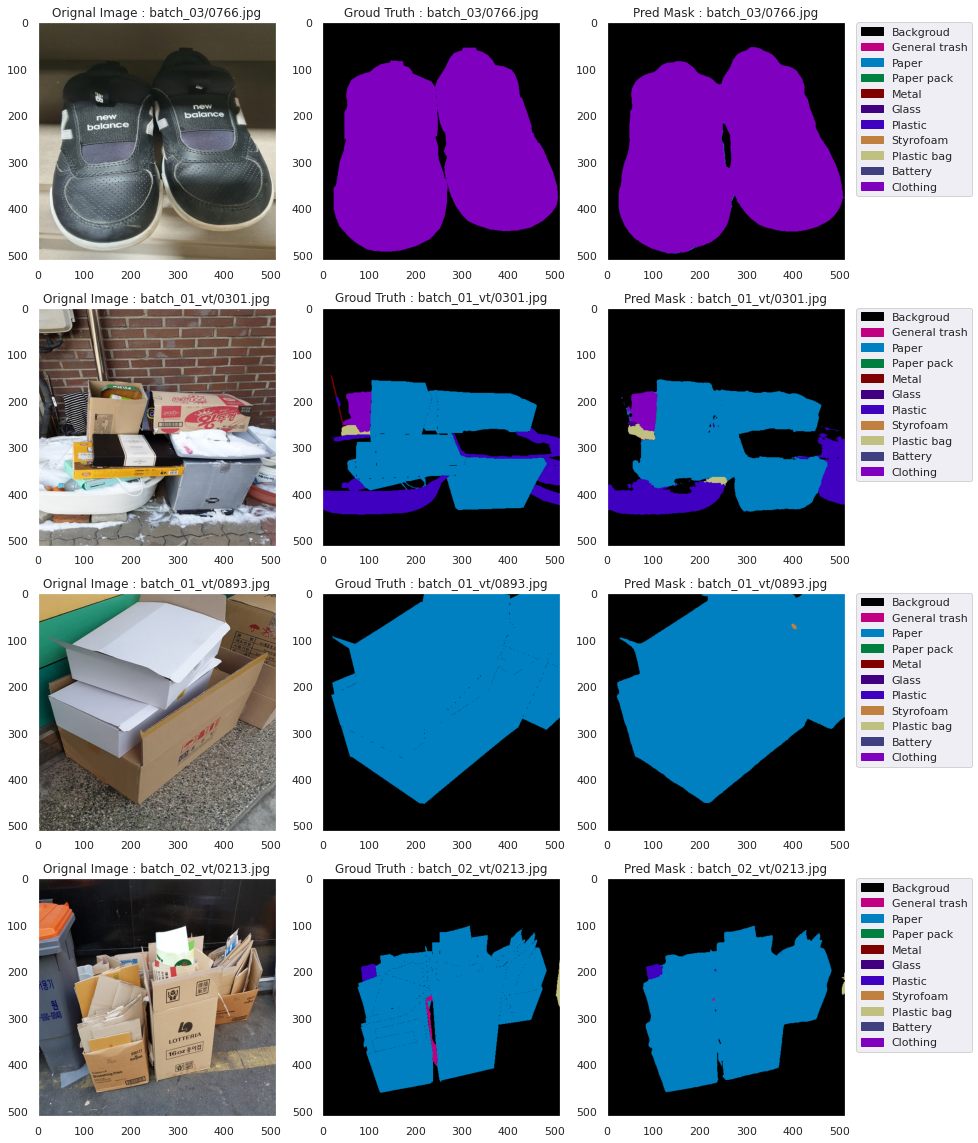

In [26]:
plot_examples(mode="train", batch_id=7, num_examples=4, dataloaer=train_loader)

#### validation set 시각화

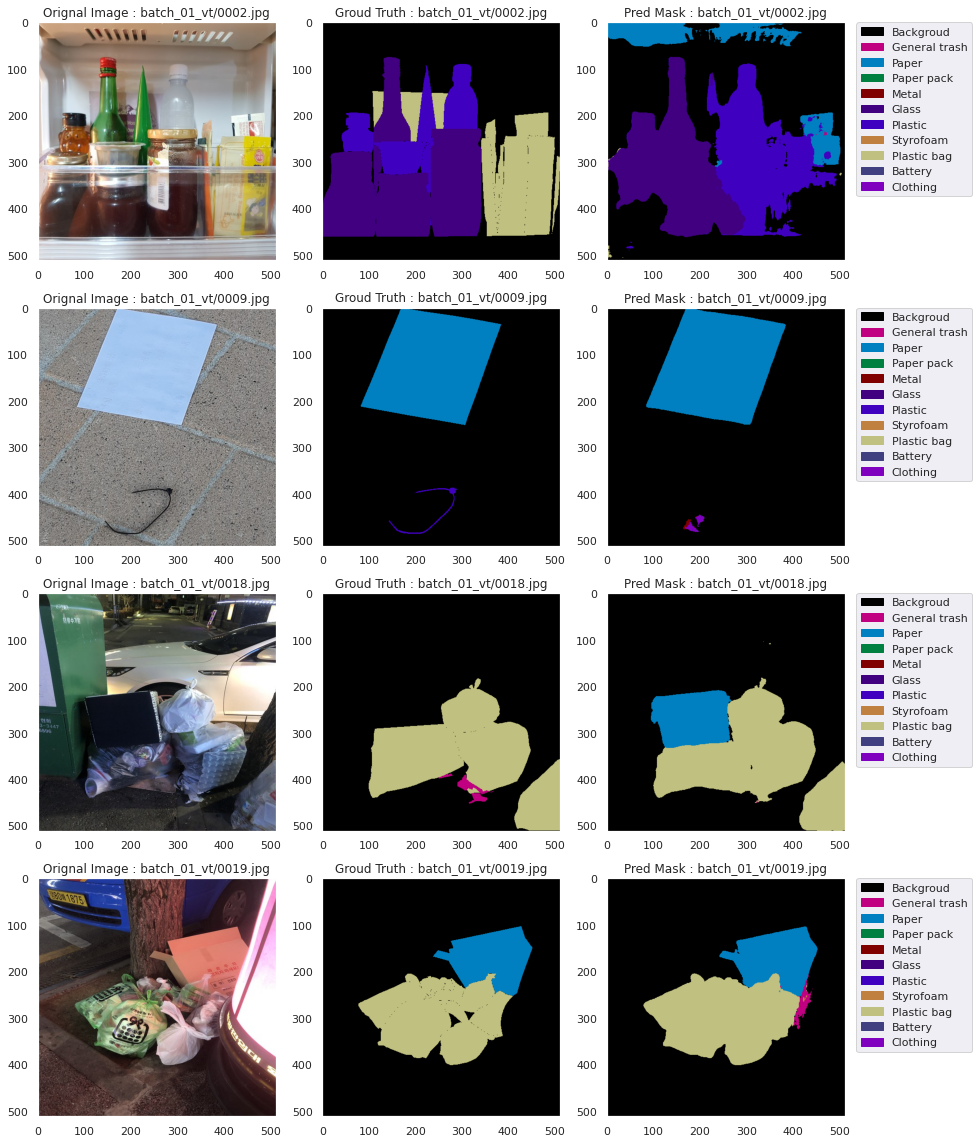

In [27]:
plot_examples(mode="val", batch_id=0, num_examples=4, dataloaer=val_loader)

#### test set 시각화

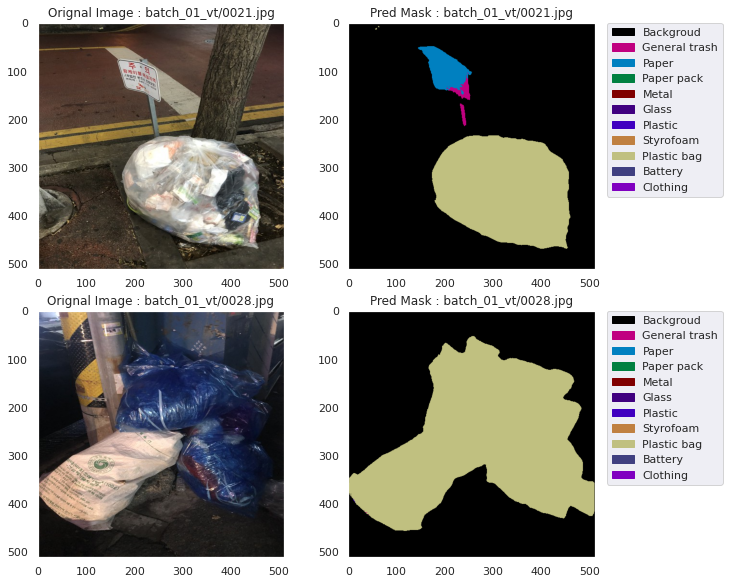

In [28]:
plot_examples(mode="test", batch_id=0, num_examples=2, dataloaer=test_loader)

## submission을 위한 test 함수 정의

In [29]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    print('Start prediction.')
    
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [30]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/Unet_best_model_epoch.csv", index=False)

  0%|          | 0/52 [00:00<?, ?it/s]

Start prediction.


100%|██████████| 52/52 [06:51<00:00,  6.10s/it]


End prediction.
